# **HW2 電腦模擬車**



In [59]:
import os
from google.colab import drive
drive.mount("/content/drive")

path = "/content/drive/Othercomputers/My Computer/Adrien88/1-year graduate school/Fall/Neural Network/HW2"
os.chdir(path)
print("You are now in: \"{}\"\n".format(os.getcwd()))

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
You are now in: "/content/drive/Othercomputers/My Computer/Adrien88/1-year graduate school/Fall/Neural Network/HW2"



In [60]:
# file path

track_coordinate_path = "./data/軌道座標點.txt"
train4dAll_path = "./data/train4dAll.txt"
train6dAll_path = "./data/train6dAll.txt"

## **File Path**

In [61]:
import numpy as np

In [62]:
track_coordinate_file = np.genfromtxt(track_coordinate_path, dtype=str, delimiter="\t")
train4dAll_file = np.genfromtxt(train4dAll_path, dtype="f", delimiter=" ")
train6dAll_file = np.genfromtxt(train6dAll_path, dtype="f", delimiter=" ")

## **Processing the File**

### **Track Coordinate**

In [63]:
track_coordinate = []
for coordinate in track_coordinate_file:
    track_coordinate.append(list(map(int, coordinate.split(",")))) # convert list of string to int

In [64]:
vehicle_origin = track_coordinate[0]
vehicle_origin_point = [vehicle_origin[0], vehicle_origin[1]]
Vehicle_Radius = 3
vehicle_origin_theta = vehicle_origin[2]

# finish_rect is the rectangle of finish region
finish_rect_left_up_coordinate = track_coordinate[1]
finish_rect_right_down_coordinate = track_coordinate[2]

finish_rect_left_down_coordinate = [finish_rect_left_up_coordinate[0], finish_rect_right_down_coordinate[1]]
finish_rect_width = finish_rect_right_down_coordinate[0] - finish_rect_left_up_coordinate[0]
finish_rect_height = finish_rect_left_up_coordinate[1] - finish_rect_right_down_coordinate[1]

In [65]:
# wall is a list to store the wall points
# ex: wall = [wall1[], wall2[], ..., walln[]]
wall = []

In [66]:
for i in range(3, len(track_coordinate)-1):
    # two_point is like (x1, y1)
    two_point = [track_coordinate[i], track_coordinate[i+1]]
    # wall is like [[(x1, y1), (x2, y2)], [(x2, y2), (x3, y3)], ..., [(x_n-1, y_n-1), (xn, yn)]]
    wall.append(two_point)

In [67]:
from sympy import Symbol
from sympy.solvers import solve

In [68]:
x = Symbol('x')
y = Symbol('y')

In [69]:
# this is like [[wall1_function], [wall2_function], [], ..., []]
wall_function = [x+6, y-22, x-18, y-50, x-30, y-10, x-6, y+3]

### **Train6dAll**

In [70]:
vehicle_x_all_TA = train6dAll_file[0:58, 0].flatten()
vehicle_y_all_TA = train6dAll_file[0:58, 1].flatten()

vehicle_front_dist_all_TA = train6dAll_file[0:, 2].flatten()
vehicle_left_dist_all_TA = train6dAll_file[0:, 3].flatten()
vehicle_right_dist_all_TA = train6dAll_file[0:, 4].flatten()
vehicle_dist_all_TA = train6dAll_file[0:, 2:5]

vehicle_theta_all_TA = train6dAll_file[0:, -1].flatten()

## **The Vehicle**

### **Vehicle Move**

maybe I will add the movement function here </br>
$x=x$

Sor, I'm so lazy lol.

In [71]:
import math

In [72]:
def vehicle_move(x, y, theta, empty):
    b = 6   # length of the vehicle
    x = x + math.cos(math.radians(empty)+math.radians(theta)) + (math.sin(math.radians(theta))*math.sin(math.radians(empty)))
    y = y + math.sin(math.radians(empty)+math.radians(theta)) - (math.sin(math.radians(theta))*math.cos(math.radians(empty)))
    empty = empty - math.degrees(math.asin(2*math.sin(math.radians(theta))/b))

    x = round(x, 7)
    y = round(y, 7)
    empty = round(empty, 7)
    
    return x, y, empty

### **Calculate the Distance**

In [73]:
def distance_cal(vehicle_x, vehicle_y, empty):
    # I have (x, y) so I can calculate the slope by using empty.
    # Then, for this function like y=ax+c, a is the slope. Thus, c equals y-ax
    # Last, I need to change the function to be like ax+y+c=0, so ax-y+c is the function I want
    c_front = vehicle_y - (math.tan(math.radians(empty)))*vehicle_x                               # calculate c_front
    vehicle_front_line = (math.tan(math.radians(empty)))*Symbol('x') - Symbol('y') + c_front      # line function of the vehicle front
    
    c_right = vehicle_y - (math.tan(math.radians(empty-45)))*vehicle_x                            # calculate c_right
    vehicle_right_line = (math.tan(math.radians(empty-45)))*Symbol('x') - Symbol('y') + c_right   # line function of the vehicle right
    
    c_left = vehicle_y - (math.tan(math.radians(empty+45)))*vehicle_x                             # calculate c_left
    vehicle_left_line = (math.tan(math.radians(empty+45)))*Symbol('x') - Symbol('y') + c_left     # line function of the vehicle left

    # 帶入牆壁的方程式去算交點
    # 回傳的是一個 [{x: , y: }, {x: , y: }, ...] 包含所有與這些線段的交點
    vehicle_front_wall_point = find_vehicle_front_all_wall_point(vehicle_front_line)
    vehicle_right_wall_point = find_vehicle_front_all_wall_point(vehicle_right_line)
    vehicle_left_wall_point = find_vehicle_front_all_wall_point(vehicle_left_line)
    #print("---------------------------------")
    #print("All right points on walls:")
    #print(vehicle_right_wall_point)
    
    # 判斷點是不是在牆壁上
    # 因為有些點並不是在"真的"牆壁上，因此要將他們刪掉
    vehicle_front_wall_point = find_point_on_wall(vehicle_front_wall_point)
    vehicle_right_wall_point = find_point_on_wall(vehicle_right_wall_point)
    vehicle_left_wall_point = find_point_on_wall(vehicle_left_wall_point)
    #print("---------------------------------")
    #print("All right points on REAL, SOLID walls:")
    #print(vehicle_right_wall_point)

    # 車子是往上還是往下
    # 車子有上下方向，也可以去刪掉一些點 ex: 0<empty<180 往上；empty=0 往右；empty=180 往左；剩下的 往下
    vehicle_front_wall_point = find_correct_direction(vehicle_front_wall_point, vehicle_x, vehicle_y, empty)
    vehicle_right_wall_point = find_correct_direction(vehicle_right_wall_point, vehicle_x, vehicle_y, empty-45)
    vehicle_left_wall_point = find_correct_direction(vehicle_left_wall_point, vehicle_x, vehicle_y, empty+45)
    #print("---------------------------------")
    #print("All right points on correct direction (up, down, ...):")
    #print(vehicle_right_wall_point)

    # 求合理(最近)的那個點
    # 因為這個對的方向還是可能會有很多點，因此求出最靠近車子的那個點 (這應該就要是正確的那個點了)
    vehicle_front_wall_point = find_closest_point(vehicle_front_wall_point, vehicle_x, vehicle_y)
    vehicle_right_wall_point = find_closest_point(vehicle_right_wall_point, vehicle_x, vehicle_y)
    vehicle_left_wall_point = find_closest_point(vehicle_left_wall_point, vehicle_x, vehicle_y)
    #print("All right points which are closest to the vehicle (it should be the only correct answer):")
    #print(vehicle_right_wall_point)
    if len(vehicle_right_wall_point)>1: print("Something went wrong!!!")    # 檢查錯誤

    # 計算車子前方到牆壁的距離
    front_dist = cal_dist(vehicle_front_wall_point[0], vehicle_x, vehicle_y)
    right_dist = cal_dist(vehicle_right_wall_point[0], vehicle_x, vehicle_y)
    left_dist = cal_dist(vehicle_left_wall_point[0], vehicle_x, vehicle_y)
    #print("The distance in front of the vehicle: {}".format(front_dist))
    #print("The distance left of the vehicle: {}".format(left_dist))
    #print("The distance right of the vehicle: {}".format(right_dist))

    return vehicle_front_wall_point[0], front_dist,\
            vehicle_right_wall_point[0], right_dist,\
            vehicle_left_wall_point[0], left_dist

#### **Find all the points on the walls in front of the vehicle**

In [74]:
def find_vehicle_front_all_wall_point(line_function):
    all_points = []   # 存所有的交點 list
    point = dict()    # 算出的一個交點 dict{x: , y:}
    x = Symbol('x')
    y = Symbol('y')
    line1 = line_function
    for line2 in wall_function:
        function = [line1, line2]
        answer = solve(function, [x, y])
        if (answer!=[] and answer[x]>=-6 and answer[x]<=30 and answer[y]>=-3 and answer[y]<=50):
            point = {'x': answer[x], 'y': answer[y]}
            all_points.append(point)
    return all_points

#### **Find whether those points are on the REAL, SOLID walls**

In [75]:
def find_point_on_wall(points):
    points_on_wall = []
    for i, point in enumerate(points):
        # 判斷水平線的 (y固定)
        if point['y']==-3:
            if (point['x']>=-6 and point['x']<=6): points_on_wall.append(points[i])
        elif point['y']==10:
            if (point['x']>=6 and point['x']<=30): points_on_wall.append(points[i])
        elif point['y']==22:
            if (point['x']>=-6 and point['x']<=18): points_on_wall.append(points[i])
        elif point['y']==50:
            if (point['x']>=18 and point['x']<=30): points_on_wall.append(points[i])
        
        # 判斷垂直線的 (x固定)
        if point['x']==-6:
            if (point['y']>=-3 and point['y']<=22): points_on_wall.append(points[i])
        elif point['x']==6:
            if (point['y']>=-3 and point['y']<=10): points_on_wall.append(points[i])
        elif point['x']==18:
            if (point['y']>=22 and point['y']<=50): points_on_wall.append(points[i])
        elif point['x']==30:
            if (point['y']>=10 and point['y']<=50): points_on_wall.append(points[i])
    return points_on_wall

#### **Determine whether this point is on the correct direction**

In [76]:
# 分成 上，右，左，下 討論
def find_correct_direction(points, vehicle_x, vehicle_y, empty):
    point_correct_direction = []
    if 0<empty<180:
        for i, point in enumerate(points):
            if point['y']>vehicle_y: point_correct_direction.append(points[i])
    elif empty==0:
        for i, point in enumerate(points):
            if point['x']>vehicle_x: point_correct_direction.append(points[i])
    elif empty==180:
        for i, point in enumerate(points):
            if point['x']<vehicle_x: point_correct_direction.append(points[i])
    else:
        for i, point in enumerate(points):
            if point['y']<vehicle_y: point_correct_direction.append(points[i])
    return point_correct_direction

#### **Find the closest point**
The point should be the only correct point in front of the vehicle.

In [77]:
def find_closest_point(points, vehicle_x, vehicle_y):
    min_distance = 100
    closest_points = []
    min_distance_point = []
    for i, point in enumerate(points):
        vehicle_point_distance = math.sqrt(np.square(point['x']-vehicle_x)+np.square(point['y']-vehicle_y))
        if vehicle_point_distance < min_distance:
            min_distance = vehicle_point_distance
            min_distance_point = points[i]
    closest_points.append(min_distance_point)
    return closest_points

#### **Calculate the distance between the vehicle and wall**

In [78]:
def cal_dist(point, vehicle_x, vehicle_y):
    dist = math.sqrt(np.square(point['x']-vehicle_x)+np.square(point['y']-vehicle_y))
    dist = round(dist, 7)
    return dist

## **RBF**

Description of RBF in this case.
We have three types of data (distance ahead, left, right of the vehicle, respectively), and we want to predict another data (theta).

So, the input is three dimention, and output is one.


### **Drawing the data relation picture.**

In [79]:
import matplotlib.pyplot as plt

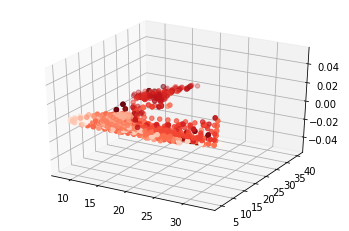

In [80]:
fig = plt.figure()

ax = fig.add_subplot(projection='3d')

x = vehicle_front_dist_all_TA
y = vehicle_left_dist_all_TA
z = vehicle_right_dist_all_TA
category = vehicle_theta_all_TA

ax.scatter(x, y, marker='o', c=category, cmap='Reds')

plt.show()

### **K-means**

In [81]:
import time

In [82]:
def kmeans(X, k, max_iters):
    start = time.time()

    centroids = X[np.random.choice(range(len(X)), k, replace=False)]
    # this centroids is the first randomly choosed among data points
    # "replace" means there will not generate repeated number in the list
    cluster_list = [[] for i in range(len(centroids))]    # generate k cluster_list, k is the number of centroids

    converged = False
    current_iter = 0
    
    while (not converged) and (current_iter < max_iters):
        print("This is iteration: {}th.".format(current_iter))
        prev_centroids = centroids
        for x in X:   # Go through each data point
            distance_list = []
            for c in centroids:
                dist = get_distance(x, c)
                distance_list.append(dist)    # Store each distance between x and c respectively
            cluster_list[np.argmin(distance_list)].append(x)   # argmin is find the minimum in the given list
        
        # fxxk, 我終於找到為甚麼會一直錯了...(11/17/2021   - 00:48)
        # 因為如果有兩個座標一模一樣的點都被當成是中心點的話，那這兩個直到這兩個中心點的距離都是0(廢話)
        # 然後 distance_list 會有兩個地方都是0(也就是到那兩個中心點的距離)
        # 但是 np.argmin(distance_list) 只會回傳第一個0的index，也因此就會有群是空的 (Oh My God)
        
        cluster_list = list((filter(None, cluster_list)))
        # 這裡負責刪掉空的群

        centroids = [np.mean(cluster_list[i], axis=0) for i in range(len(cluster_list))]    # 在每一個cluster中，沿著column的方向找平均值 (寫成一行有點開心)
        
        error = np.sum([np.abs(centroids[i]-prev_centroids[i]) for i in range(len(centroids))])
        # error = 每個中心點誤差的加總
        if (error < 0.1):   # 誤差小於0.1就讓他收斂
            converged = True
            print("K-means has converged.")

        current_iter+=1
    
    print("The iteration stopped at {}th".format(current_iter))
    print("Now, we have {} clusters(centroids).".format(len(cluster_list)))
    std = [np.std(x) for x in cluster_list]
    
    end = time.time()
    print("K-means execution time: {}s.".format(end-start))

    return np.array(centroids), std   # Change type list to array

#### **Get distance**

In [83]:
def get_distance(x, c):
    sum = 0
    for i in range(len(x)):
        sum = sum + (x[i]-c[i])**2
    dist = np.sqrt(sum)

    return dist

In [84]:
# 拿來測試用的，因為每次要跑 RBF都要在跑一次 kmeans，真的有夠麻煩
#centroids_outside, std_outside = kmeans(vehicle_dist_all_TA, k=100, max_iters=100)

### **RBF Neural Network**

#### **RBF Model**

In [85]:
class RBFNN:
    def __init__(self, X, y, k):
        self.X = X
        self.y = np.reshape(y, (-1, 1))
        self.k = k    # 分k群
        self.centroids, self.std_list = kmeans(self.X, self.k, max_iters=100)   # 最多迭代100次
        self.k = len(self.centroids)    # 因為k會變少 (有些中心點會不見，可參考上面的function)
        self.bias = 1
        self.w = np.reshape(np.array([1 for i in range(self.k)]), (-1, 1))      # w is a (58, 1) array

    def rbf(self, x, c, s):
        dist = get_distance(x, c)
        radius_basis = np.exp(-(dist/(2*(s**2))))   # Gaussian function
        return radius_basis

    def phi_array(self, X, centroids, std):
        phi_list = []
        for x in X:
            phi_list.append([self.rbf(x, c, s) for (c, s) in zip(centroids, std)])
            # phi_list.shape = (p, j). rows: number of X, columns: number of phi
        return np.array(phi_list)

    def train(self, lr, n_epochs):
        self.bias = 1
        prev_bias = self.bias
        self.w = np.reshape(np.array([1 for i in range(self.k)]), (-1, 1))    # w is a (58, 1) array
        prev_w = self.w

        phi = self.phi_array(self.X, self.centroids, self.std_list)   # hidden layer matrix
        # phi is a (number_of_data, number_of_centroids) array(matrix)

        min_loss = 10000
        for epoch in range(n_epochs):
            for i in range(len(self.X)):
                phi_i = np.reshape(phi[i], (-1, self.k))    # phi_i is a (1, 58) array
                F = np.dot(phi_i, self.w) + self.bias

                self.w = self.w + lr*(self.y[i]-F)*np.reshape(phi_i, (-1, 1))
                self.bias = self.bias + lr*(self.y[i]-F)

            pred_y = np.dot(phi, self.w) + self.bias
            mse_loss = np.square(self.y-pred_y).mean(axis=0)
            print("This is {}/{} epoch.     Loss: {}".format(epoch, n_epochs, mse_loss))
            if mse_loss < min_loss:
                print("Save this new w and bias.")
        
    def predict(self, X_pred):
        y_pred = []
        phi = self.phi_array(X_pred, self.centroids, self.std_list)
        for i in range(X_pred.shape[0]):
            phi_i = np.reshape(phi[i], (-1, self.k))    # phi_i is a (1, 58) array
            F = np.dot(phi_i, self.w) + self.bias
            y_pred.append(F)

        return np.array(y_pred)

In [86]:
Cluster_num = 100   # 分成100群

In [87]:
RBF = RBFNN(vehicle_dist_all_TA, vehicle_theta_all_TA, Cluster_num)

This is iteration: 0th.
This is iteration: 1th.
This is iteration: 2th.
This is iteration: 3th.
This is iteration: 4th.
This is iteration: 5th.
This is iteration: 6th.
This is iteration: 7th.
This is iteration: 8th.
This is iteration: 9th.
This is iteration: 10th.
This is iteration: 11th.
This is iteration: 12th.
This is iteration: 13th.
This is iteration: 14th.
This is iteration: 15th.
This is iteration: 16th.
This is iteration: 17th.
This is iteration: 18th.
This is iteration: 19th.
This is iteration: 20th.
This is iteration: 21th.
This is iteration: 22th.
This is iteration: 23th.
This is iteration: 24th.
This is iteration: 25th.
This is iteration: 26th.
This is iteration: 27th.
This is iteration: 28th.
This is iteration: 29th.
This is iteration: 30th.
This is iteration: 31th.
This is iteration: 32th.
This is iteration: 33th.
This is iteration: 34th.
This is iteration: 35th.
This is iteration: 36th.
This is iteration: 37th.
This is iteration: 38th.
This is iteration: 39th.
This is it

In [88]:
start = time.time()
RBF.train(lr=0.0001, n_epochs=500)
end = time.time()
print("Train RBF execution time: {}.".format(end-start))

This is 0/500 epoch.     Loss: [296.75007256]
Save this new w and bias.
This is 1/500 epoch.     Loss: [292.1331406]
Save this new w and bias.
This is 2/500 epoch.     Loss: [287.66168897]
Save this new w and bias.
This is 3/500 epoch.     Loss: [283.33907284]
Save this new w and bias.
This is 4/500 epoch.     Loss: [279.1597436]
Save this new w and bias.
This is 5/500 epoch.     Loss: [275.11842174]
Save this new w and bias.
This is 6/500 epoch.     Loss: [271.21007782]
Save this new w and bias.
This is 7/500 epoch.     Loss: [267.4299149]
Save this new w and bias.
This is 8/500 epoch.     Loss: [263.77335275]
Save this new w and bias.
This is 9/500 epoch.     Loss: [260.23601344]
Save this new w and bias.
This is 10/500 epoch.     Loss: [256.81370841]
Save this new w and bias.
This is 11/500 epoch.     Loss: [253.50242663]
Save this new w and bias.
This is 12/500 epoch.     Loss: [250.29832386]
Save this new w and bias.
This is 13/500 epoch.     Loss: [247.19771288]
Save this new w a

#### **RBF predict**

In [89]:
y_pred = RBF.predict(vehicle_dist_all_TA).flatten()
test_pred = RBF.predict(np.array([[20.0000, 8.4853, 8.4853]]))

#### **Draw the RBF result.**

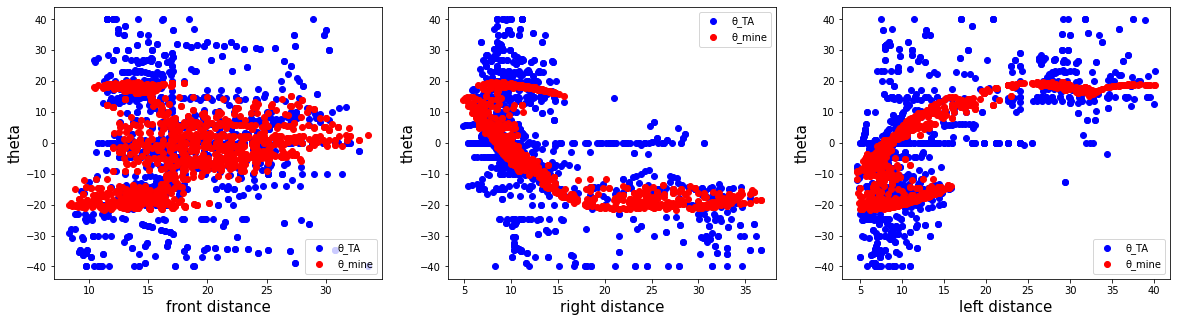

In [90]:
fig, ax = plt.subplots(1, 3, figsize=(20, 5), sharex='none', sharey='none')

x_TA = vehicle_front_dist_all_TA
y_TA = vehicle_theta_all_TA

ax[0].scatter(x_TA, y_TA, color="blue", marker='o', label="θ_TA")
ax[0].scatter(x_TA, y_pred, color="red", marker='o', label="θ_mine")
ax[0].set_xlabel("front distance", fontsize="15")
ax[0].set_ylabel("theta", fontsize="15")
ax[0].legend()

x_TA = vehicle_right_dist_all_TA

ax[1].scatter(x_TA, y_TA, color="blue", marker='o', label="θ_TA")
ax[1].scatter(x_TA, y_pred, color="red", marker='o', label="θ_mine")
ax[1].set_xlabel("right distance", fontsize="15")
ax[1].set_ylabel("theta", fontsize="15")
ax[1].legend()

x_TA = vehicle_left_dist_all_TA

ax[2].scatter(x_TA, y_TA, color="blue", marker='o', label="θ_TA")
ax[2].scatter(x_TA, y_pred, color="red", marker='o', label="θ_mine")
ax[2].set_xlabel("left distance", fontsize="15")
ax[2].set_ylabel("theta", fontsize="15")
ax[2].legend()

plt.show()

## **Drawing**

In [91]:
import matplotlib.patches as patches
import matplotlib.animation as animation

In [104]:
def drawing(vehicle_x_all, vehicle_y_all, vehicle_front_point_all, vehicle_front_dist_all,
            vehicle_right_point_all, vehicle_right_dist_all,
            vehicle_left_point_all, vehicle_left_dist_all, frames, theta):
    fig, ax = plt.subplots(figsize=(6,6))
    plt.xlim(-20, 50)
    plt.ylim(-10, 60)

    # draw all the walls
    for x in wall:
        # ax.plot([x1, x2], [y1, y2]), it is so weird..., but convenient for programming haha
        ax.plot([x[0][0], x[1][0]], [x[0][1], x[1][1]], color="blue")
    ax.plot([-12, 12], [0, 0], color="black")

    # the finish rectangle is, patches.Rectangle([left down point], width, height, ...)
    finish_rect = patches.Rectangle(finish_rect_left_down_coordinate, finish_rect_width, finish_rect_height, linewidth=2, edgecolor="r", facecolor="none")
    ax.add_patch(finish_rect)

    # the vehicle shape is a circle
    vehicle = plt.Circle((0, 0), Vehicle_Radius, linewidth="1", edgecolor="black", fill=False, label="Vehicle")
    ax.add_artist(vehicle)

    # show the text of the distance in front of vehicle
    vehicle_front_dist_text = ax.text(-17, 57, "Front distance", fontsize=10, color='black')
    vehicle_right_dist_text = ax.text(-17, 54, "Right distance", fontsize=10, color='black')
    vehicle_left_dist_text = ax.text(-17, 51, "Left distance", fontsize=10, color='black')
    
    # add a direction line animation
    # should add a COMMA "," after the line, I'm so confused. I spent a lot of time to deal with this bug, Shit.
    vehicle_front_direction_line, = ax.plot([0,0], [0,0], color='b', linewidth=1)
    vehicle_right_direction_line, = ax.plot([0,0], [0,0], color='b', linewidth=1)
    vehicle_left_direction_line, = ax.plot([0,0], [0,0], color='b', linewidth=1)

    def init():
        vehicle.center = (0, 0)
        vehicle_front_dist_text.set_text("Front distance: {}".format("unknown"))
        vehicle_right_dist_text.set_text("Right distance: {}".format("unknown"))
        vehicle_left_dist_text.set_text("Left distance : {}".format("unknown"))

        return vehicle, vehicle_front_dist_text, vehicle_right_dist_text, vehicle_left_dist_text
        # why add a comma here?
        # cause vehicle is a tuple, like vehicle(xy=(0, 0), radius=3)
        # we only want the first thing in this tuple

    def animate(i):
        # vehicle movement animation
        vehicle_loc_x = vehicle_x_all[i]
        vehicle_loc_y = vehicle_y_all[i]
        vehicle.center = (vehicle_loc_x, vehicle_loc_y)

        # add distance text animation
        vehicle_front_dist_text.set_text("Front distance : {:.5f}".format(vehicle_front_dist_all[i]))
        vehicle_right_dist_text.set_text("Right distance : {:.5f}".format(vehicle_right_dist_all[i]))
        vehicle_left_dist_text.set_text("Left distance   : {:.5f}".format(vehicle_left_dist_all[i]))

        # add front direction line animation, (it costed me so much effort, but it was amazing)
        vehicle_front_direction_x = [vehicle_loc_x, vehicle_front_point_all[i]['x']]
        vehicle_front_direction_y = [vehicle_loc_y, vehicle_front_point_all[i]['y']]
        vehicle_right_direction_x = [vehicle_loc_x, vehicle_right_point_all[i]['x']]
        vehicle_right_direction_y = [vehicle_loc_y, vehicle_right_point_all[i]['y']]
        vehicle_left_direction_x = [vehicle_loc_x, vehicle_left_point_all[i]['x']]
        vehicle_left_direction_y = [vehicle_loc_y, vehicle_left_point_all[i]['y']]

        vehicle_front_direction_line.set_data(vehicle_front_direction_x, vehicle_front_direction_y)
        vehicle_right_direction_line.set_data(vehicle_right_direction_x, vehicle_right_direction_y)
        vehicle_left_direction_line.set_data(vehicle_left_direction_x, vehicle_left_direction_y)
        
        return vehicle, vehicle_front_dist_text, vehicle_front_direction_line,\
                vehicle_right_dist_text, vehicle_right_direction_line,\
                vehicle_left_dist_text, vehicle_left_direction_line

    anim = animation.FuncAnimation(fig=fig, func=animate, init_func=init, frames=frames, interval=100, blit=False, repeat=False)
    ax.set_title("Adrien Go")
    plt.show()
    anim.save("./gif/Adrien_go.gif", writer="pillow", fps=3)

## **Run the vehicle**

Steps:
1. 起點的資料會給: (x, y, empty)
2. 將 (x, y, empty) -> 計算距離演算法(distance_cal) -> 前,右,左(3個距離)
3. 將這3個距離 -> RBF模型(RBF.predict) -> theta
4. 將 (x, y, theta, empty) -> 車子的移動演算法(vehicle_move) -> (x_next, y_next, empty_next)
5. 回 Step2 計算距離


In [93]:
def letsgo(x, y, empty):
    predict4dAll = []
    predict6dAll = []
    front_point_all = []
    right_point_all = []
    left_point_all = []
    vehicle_step_num = 0

    reach_finish_line = False

    while not reach_finish_line:
        print("-------------------------------")
        print("Vehicle step number: {}".format(vehicle_step_num))
        # Step 2
        front_point, front_dist, right_point, right_dist, left_point, left_dist = distance_cal(x, y, empty)

        # Step 3
        all_dist = np.array([[front_dist, right_dist, left_dist]])
        theta = RBF.predict(all_dist)
        print("theta: {}".format(theta))

        predict4dAll.append([front_dist, right_dist, left_dist, theta])
        predict6dAll.append([x, y, front_dist, right_dist, left_dist, theta])
        front_point_all.append(front_point)
        right_point_all.append(right_point)
        left_point_all.append(left_point)

        # Step 4
        x_next, y_next, empty_next = vehicle_move(x, y, theta, empty)
        print("x_next: {}".format(x_next))
        print("y_next: {}".format(y_next))
        print("empty_next: {}".format(empty_next))

        
        if (18<x<30) & (y-3>37):
            reach_finish_line = True
            print("Congratulation, You reached the finish line!!")

        x = x_next
        y = y_next
        empty = empty_next

        vehicle_step_num += 1

    return predict4dAll, predict6dAll, front_point_all, right_point_all, left_point_all

In [94]:
predict4dAll, predict6dAll, front_point_all, right_point_all, left_point_all\
 = letsgo(vehicle_origin[0], vehicle_origin[1], vehicle_origin[2])

-------------------------------
Vehicle step number: 0
theta: [[[0.39730964]]]
x_next: 0.0
y_next: 0.999976
empty_next: 89.8675644
-------------------------------
Vehicle step number: 1
theta: [[[0.20096166]]]
x_next: 0.0023114
y_next: 1.9999672
empty_next: 89.8005773
-------------------------------
Vehicle step number: 2
theta: [[[0.03832282]]]
x_next: 0.005792
y_next: 2.9999609
empty_next: 89.787803
-------------------------------
Vehicle step number: 3
theta: [[[-0.09810197]]]
x_next: 0.0094955
y_next: 3.9999526
empty_next: 89.8205036
-------------------------------
Vehicle step number: 4
theta: [[[-0.22470754]]]
x_next: 0.0126283
y_next: 4.99994
empty_next: 89.8954059
-------------------------------
Vehicle step number: 5
theta: [[[19.25739611]]]
x_next: 0.0143517
y_next: 5.9439849
empty_next: 83.5836929
-------------------------------
Vehicle step number: 6
theta: [[[18.91340957]]]
x_next: 0.1200699
y_next: 6.8840688
empty_next: 77.3809887
-------------------------------
Vehicle s

### **Draw the run result**

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify '

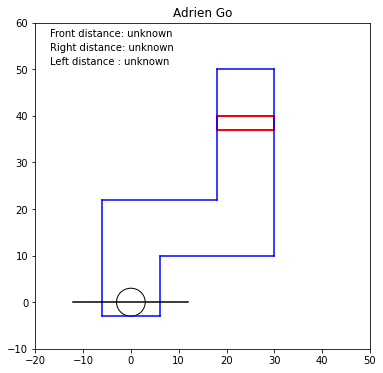

In [105]:
vehicle_x_all = np.array(predict6dAll)[:, 0]
vehicle_y_all = np.array(predict6dAll)[:, 1]
front_point_all = np.array(front_point_all)
front_dist_all = np.array(predict6dAll)[:, 2]
right_point_all = np.array(right_point_all)
right_dist_all = np.array(predict6dAll)[:, 3]
left_point_all = np.array(left_point_all)
left_dist_all = np.array(predict6dAll)[:, 4]

frames = len(vehicle_x_all)

drawing(vehicle_x_all, vehicle_y_all, front_point_all, front_dist_all,
            right_point_all, right_dist_all,
            left_point_all, left_dist_all, frames, theta=0)   # 因為動畫沒有要秀出theta，我就隨便設

## **Save Result**

In [96]:
def save(train4Dfile_path, train6Dfile_path, predict4dAll, predict6dAll):
    print("Saving results to {}".format(train4Dfile_path))
    with open(train4Dfile_path, 'w') as f:
        for element in predict4dAll:
            f.write("{:10.7f} {:10.7f} {:10.7f} {:11.7f}".format(element[0], element[1], element[2], element[3].item()))
            f.write("\n")

    print("Saving results to {}".format(train6Dfile_path))
    with open(train6Dfile_path, 'w') as f:
        for element in predict6dAll:
            f.write("{:10.7f} {:10.7f} {:10.7f} {:10.7f} {:10.7f} {:11.7f}".format(element[0], element[1], element[2], element[3], element[4], element[5].item()))
            f.write("\n")

In [98]:
train4Dfile_path = "./data/train4Dfile.txt"
train6Dfile_path = "./data/train6Dfile.txt"

save(train4Dfile_path, train6Dfile_path, predict4dAll, predict6dAll)

Saving results to ./data/train4Dfile.txt
Saving results to ./data/train6Dfile.txt
